In [1]:
# Core analysis packages
import numpy as np
import os, sys
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import anova
from patsy import dmatrices
import bff
import pingouin as pg

# Plotting packages
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns 
sns.set(style="ticks", color_codes=True)
sns.set_style("white")
sns.set_style({'xtick.bottom': True, 'ytick.left': True})
colorref = ["gray", "royalblue", "crimson", "goldenrod", "mediumorchid", "seagreen"]


# iPython magic commands
%matplotlib notebook
%load_ext autoreload
%autoreload 2
%autosave 120

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIG_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)  # fontsize of the figure title
cust_palette = sns.color_palette("Paired")[6:10]
cust_palette = [cust_palette[i] for i in [1,0,3,2]]

def median_split(S):
    return S > S.median()

/opt/anaconda3/envs/research/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.9.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


Autosaving every 120 seconds


In [2]:
def ttest_ind(x1, x2, equivar=False, alpha=0.05, printres=False):
    n1 = len(x1)
    M1 = np.mean(x1)
    s1 = np.std(x1, ddof=1)
    n2 = len(x2)
    M2 = np.mean(x2)
    s2 = np.std(x2, ddof=1)
    
    # t-test
    [t, p] = stats.ttest_ind(x1, x2, equal_var=equivar)
    # cohen's d
    dof = n1 + n2 - 2
    sp = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / dof)
    d = np.abs(M1 - M2) / sp
    # degrees of freedom
    df = (s1**2/n1 + s2**2/n2)**2 / ((s1**2/n1)**2/(n1-1) + (s2**2/n2)**2/(n2-1))
    # confidence intervals (M1 - M2) ± ts(M1 - M2)
    se = np.sqrt(sp**2/n1 + sp**2/n2)
    CI = (M1 - M2) + np.array([-1,1])*stats.t.ppf(1-alpha/2, df, loc=0, scale=1)*se

    res = (t, df, p, d, CI[0], CI[1])
    if printres:
        print("t = %.5f, df = %.5f, p = %.5f, d = %.5f, CI = (%.5f, %.5f)" % res)
    else:
        return res

In [3]:
# Load file (from same directory as the notebook)
df = pd.read_excel(os.path.expanduser("belief2behavPolitical.xlsx"), index_col=0)
df.head()

,Unnamed: 1,BeliefPRE1,BeliefPRE2,BeliefPRE3,BeliefPRE4,BeliefPRE5,BeliefPRE6,BeliefPRE7,BeliefPRE8,BehavPRE1,...,ChoicePOSTi,ChoicePOSTd,Bchangei,Bchanged,Cchangei,Cchanged,BeliefPREi,BeliefPREd,ChoicePREi,ChoicePREd
Response ID,,,,,,,,,,,,,,,,,,,,,
R_306Q0as0pGObo9U,NaN,24,50,96,82,6,0,22,88,0,...,1.25,1.25,58.00,-23.50,1.25,-1.25,20.00,72.00,0.0,2.5
R_2DS0co0DB3gjvFm,NaN,10,69,69,30,34,68,52,61,0,...,1.25,1.25,54.75,-40.50,1.25,-1.25,45.25,53.00,0.0,2.5
R_2E06Hy20Kiq5ZxC,NaN,13,0,72,66,19,25,32,71,0,...,2.50,0.00,29.00,-24.25,2.50,-2.50,14.25,60.25,0.0,2.5
R_2E5mK5O0wo21WUD,NaN,70,61,92,100,84,30,0,59,4,...,2.25,0.25,19.00,-36.25,0.75,-0.75,61.25,62.75,1.5,1.0
R_1DNA8WofrgHPtcM,NaN,32,40,68,80,35,26,10,60,0,...,2.50,0.00,46.75,-44.25,2.50,0.00,33.25,54.50,0.0,0.0


In [4]:
# Extract columns with df.target or df["target"] or df.loc[:,"target"]
age = df.loc[:, "Age"]
ide = df.loc[:,"Ide"]

BeliefPOSTi = df.loc[:,"BeliefPOSTi"]
BeliefPOSTd = df.loc[:,"BeliefPOSTd"]
ChoicePOSTi = df.loc[:,"ChoicePOSTi"]
ChoicePOSTd = df.loc[:,"ChoicePOSTd"]
Bchangei = df.loc[:,"Bchangei"]
Bchanged = df.loc[:,"Bchanged"]
Cchangei = df.loc[:,"Cchangei"]
Cchanged = df.loc[:,"Cchanged"]

partnum = np.arange(ide.size)

In [5]:
# Extract data with df.loc[:,"datastart":"dataend"]
BeliefPRE = df.loc[:, "BeliefPRE1":"BeliefPRE8"]
BeliefPOST = df.loc[:, "BeliefPOST1":"BeliefPOST8"]
ChoicePRE = df.loc[:, "BehavPRE1":"BehavPRE8"]
ChoicePOST = df.loc[:, "BehavPOST1":"BehavPOST8"]
RdeltaB = df.loc[:, "RB1":"RB8"]
RdeltaC = df.loc[:, "RC1":"RC8"]
deltaB = df.loc[:, "Bchange1":"Bchange8"]
deltaC = df.loc[:, "Cchange1":"Cchange8"]

sz = RdeltaB.shape
itemnum = np.arange(sz[-1])
print(sz)

(83, 8)


In [6]:
# Data and row-wise labels first
names = ["BeliefPRE", "BeliefPOST", "ChoicePRE", "ChoicePOST", 'RdeltaB', 'RdeltaC', 'deltaB','deltaC','itemnum', \
         "age", "ide", 'BeliefPOSTi', 'BeliefPOSTd','ChoicePOSTi','ChoicePOSTd','Bchangei','Bchanged','Cchangei','Cchanged',"partnum"]
data_packed = np.broadcast_arrays(BeliefPRE, BeliefPOST, ChoicePRE, ChoicePOST, RdeltaB, RdeltaC, deltaB, deltaC, itemnum)
# Then column-wise labels
cols = [np.tile(a, (sz[1],1)).T for a in [age, ide, BeliefPOSTi, BeliefPOSTd,ChoicePOSTi,ChoicePOSTd,Bchangei,Bchanged,Cchangei,Cchanged, partnum]]
data_packed += cols

data_unpacked = np.vstack([np.reshape(a, (1,-1), order="C") for a in data_packed]).T
DATA = pd.DataFrame(data=data_unpacked, columns=names)

DATA.head()

,BeliefPRE,BeliefPOST,ChoicePRE,ChoicePOST,RdeltaB,RdeltaC,deltaB,deltaC,itemnum,age,ide,BeliefPOSTi,BeliefPOSTd,ChoicePOSTi,ChoicePOSTd,Bchangei,Bchanged,Cchangei,Cchanged,partnum
0,24.0,93.0,0.0,2.0,69.0,2.0,69.0,2.0,0.0,NaN,3.0,78.0,48.5,1.25,1.25,58.0,-23.5,1.25,-1.25,0.0
1,50.0,86.0,0.0,3.0,36.0,3.0,36.0,3.0,1.0,NaN,3.0,78.0,48.5,1.25,1.25,58.0,-23.5,1.25,-1.25,0.0
2,96.0,73.0,5.0,5.0,23.0,0.0,-23.0,0.0,2.0,NaN,3.0,78.0,48.5,1.25,1.25,58.0,-23.5,1.25,-1.25,0.0
3,82.0,90.0,5.0,0.0,-8.0,5.0,8.0,-5.0,3.0,NaN,3.0,78.0,48.5,1.25,1.25,58.0,-23.5,1.25,-1.25,0.0
4,6.0,63.0,0.0,0.0,57.0,0.0,57.0,0.0,4.0,NaN,3.0,78.0,48.5,1.25,1.25,58.0,-23.5,1.25,-1.25,0.0


In [7]:
# Group and average data within participant
AVDATA = DATA.groupby(["partnum"], as_index=False).mean()
AVDATA.head()

,partnum,BeliefPRE,BeliefPOST,ChoicePRE,ChoicePOST,RdeltaB,RdeltaC,deltaB,deltaC,itemnum,age,ide,BeliefPOSTi,BeliefPOSTd,ChoicePOSTi,ChoicePOSTd,Bchangei,Bchanged,Cchangei,Cchanged
0,0.0,46.000,63.250,1.25,1.25,40.750,1.25,17.250,0.00,3.5,NaN,3.0,78.00,48.50,1.25,1.25,58.00,-23.50,1.25,-1.25
1,1.0,49.125,56.250,1.25,1.25,47.625,1.25,7.125,0.00,3.5,19.0,3.0,100.00,12.50,1.25,1.25,54.75,-40.50,1.25,-1.25
2,2.0,37.250,39.625,1.25,1.25,26.625,2.50,2.375,0.00,3.5,20.0,2.0,43.25,36.00,2.50,0.00,29.00,-24.25,2.50,-2.50
3,3.0,62.000,53.375,1.25,1.25,27.625,0.75,-8.625,0.00,3.5,19.0,1.0,80.25,26.50,2.25,0.25,19.00,-36.25,0.75,-0.75
4,4.0,43.875,45.125,0.00,1.25,45.500,1.25,1.250,1.25,3.5,20.0,1.0,80.00,10.25,2.50,0.00,46.75,-44.25,2.50,0.00


In [8]:
%load_ext rpy2.ipython
# %R library(lme4)
%R library(lmerTest)

import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/envs/research/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
R[write to console]: Loading required package: lme4

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step




In [9]:
%Rpush DATA

In [10]:
%%R

M <- lmer(ChoicePRE ~  BeliefPRE + (1 | partnum) + (1 | itemnum), data = DATA)
print(summary(M))

R[write to console]: boundary (singular) fit: see ?isSingular



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: ChoicePRE ~ BeliefPRE + (1 | partnum) + (1 | itemnum)
   Data: DATA

REML criterion at convergence: 2725.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7288 -0.4388 -0.1067  0.0931  5.1916 

Random effects:
 Groups   Name        Variance Std.Dev.
 partnum  (Intercept) 0.000    0.000   
 itemnum  (Intercept) 2.233    1.494   
 Residual             3.343    1.828   
Number of obs: 664, groups:  partnum, 83; itemnum, 8

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)   
(Intercept) 7.085e-01  5.544e-01 8.121e+00   1.278  0.23657   
BeliefPRE   9.176e-03  3.195e-03 6.618e+02   2.872  0.00421 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
BeliefPRE -0.275
convergence code: 0
boundary (singular) fit: see ?isSingular



In [12]:
%%R

M <- lmer(deltaC ~ deltaB + ChoicePRE + (1 | partnum) + (1 | itemnum), data = DATA)
print(summary(M))

R[write to console]: boundary (singular) fit: see ?isSingular



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: deltaC ~ deltaB + ChoicePRE + (1 | partnum) + (1 | itemnum)
   Data: DATA

REML criterion at convergence: 2789.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.4838 -0.2505 -0.0850  0.0497  4.9911 

Random effects:
 Groups   Name        Variance Std.Dev.
 partnum  (Intercept) 0.000    0.000   
 itemnum  (Intercept) 1.597    1.264   
 Residual             3.676    1.917   
Number of obs: 664, groups:  partnum, 83; itemnum, 8

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   0.725599   0.455566   7.009097   1.593    0.155    
deltaB        0.005566   0.002234 622.513493   2.492    0.013 *  
ChoicePRE    -0.707588   0.040632 659.095553 -17.415   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr) deltaB
deltaB    -0.035       
ChoicePRE -0.105  0.111
convergenc

In [13]:
# Load file (from same directory as the notebook)
df2 = pd.read_excel(os.path.expanduser("Book2P.xlsx"))
df2.head()

,Bchange,Cchange,IncDec,BeliefPOST,ChoicePOST,BeliefPRE,ChoicePRE
0,58.00,1.25,1,78.00,1.25,20.00,0.0
1,54.75,1.25,1,100.00,1.25,45.25,0.0
2,29.00,2.50,1,43.25,2.50,14.25,0.0
3,19.00,0.75,1,80.25,2.25,61.25,1.5
4,46.75,2.50,1,80.00,2.50,33.25,0.0


In [14]:
tmp = pd.melt(df2, id_vars=['IncDec'], value_vars=['BeliefPRE', 'BeliefPOST'],
                   var_name='PrePost', value_name='Belief')

tmp.loc[tmp["IncDec"]==1, :].head()

,IncDec,PrePost,Belief
0,1,BeliefPRE,20.00
1,1,BeliefPRE,45.25
2,1,BeliefPRE,14.25
3,1,BeliefPRE,61.25
4,1,BeliefPRE,33.25


<IPython.core.display.Javascript object>


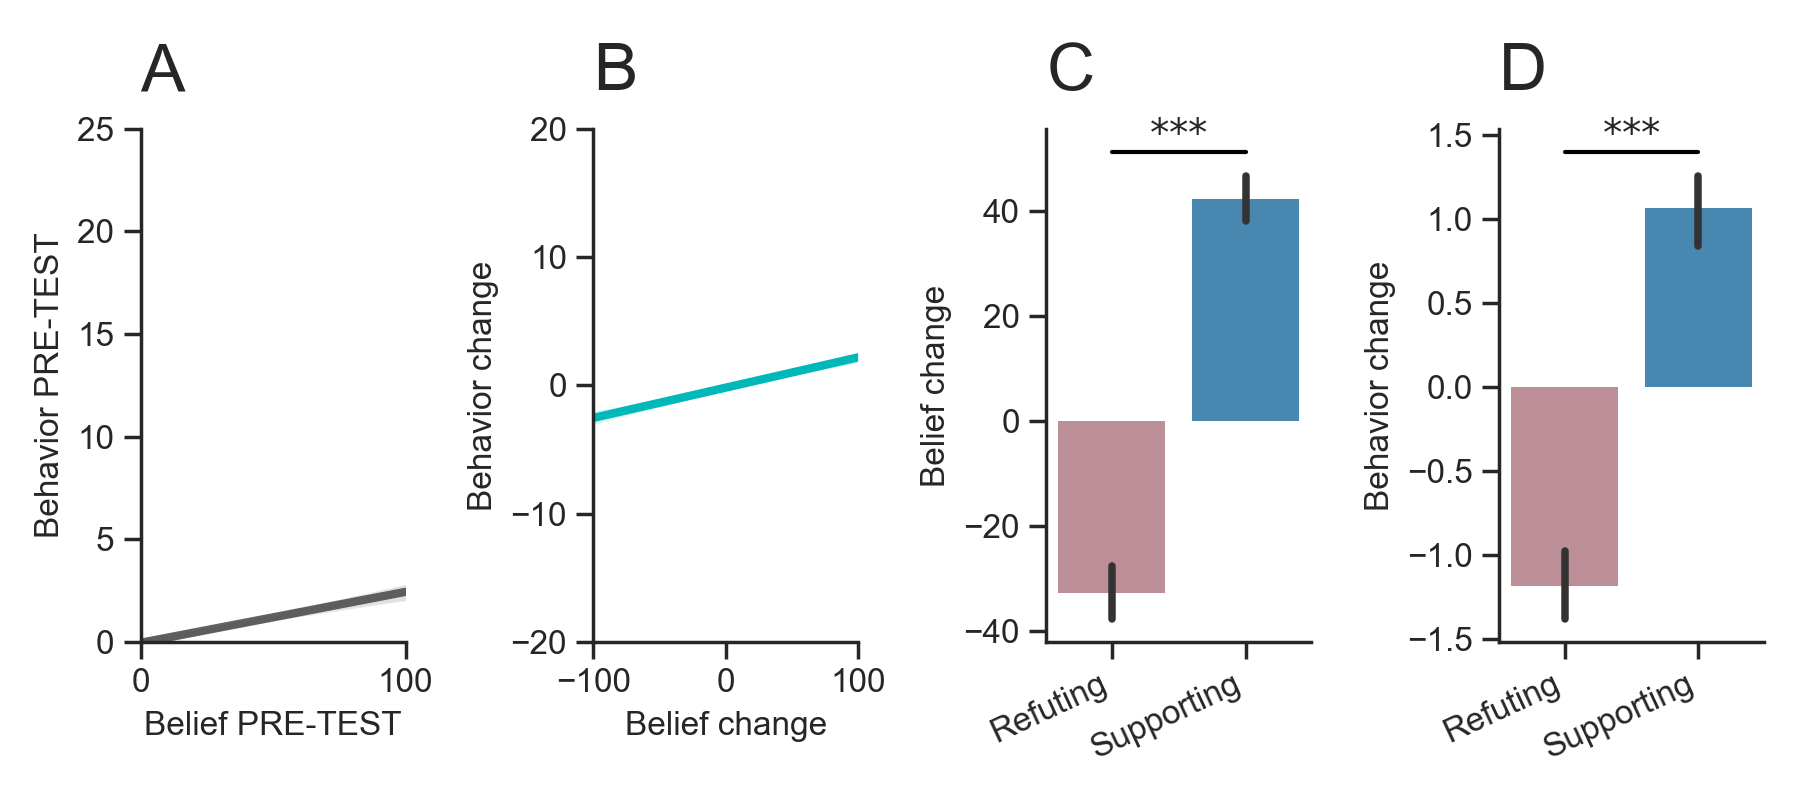

In [16]:
pal1 = ["#C48793", "#368BC1"]
pal = ["#C48793", "#368BC1"]

fig, ax = plt.subplots(1,4, figsize=(9,4))

sns.regplot(x=DATA.BeliefPRE, y=DATA.ChoicePRE, scatter_kws={"s": 0}, \
            line_kws={"color":"#3D3C3A","alpha":.8,"lw":3}, ax=ax[0])
ax[0].set_ylim(0,25)
ax[0].set_ylabel("Behavior PRE-TEST")
ax[0].set_xlabel("Belief PRE-TEST")
bff.panellabel(ax[0], "A")


sns.regplot(x=DATA.deltaB, y=DATA.deltaC, scatter_kws={"s": 0}, \
            line_kws={"color":"#00B8B8","alpha":1,"lw":3}, ax=ax[1])
ax[1].set_ylim(-20,20)
ax[1].set_ylabel("Behavior change")
ax[1].set_xlabel("Belief change")
bff.panellabel(ax[1], "B")


sns.barplot(x="IncDec", y="Bchange", data=df2, \
            palette=pal1, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[2]) 
sns.despine()
ax[2].set_xlabel("");
ax[2].set_xticklabels(['Refuting', "Supporting"], rotation=25, ha="right")
ax[2].set_ylabel("Belief change");
datahandles = np.array([L.get_xydata() for L in ax[2].get_lines()])
_, p = stats.ttest_rel(df2.loc[df2["IncDec"]==0, "Bchange"], \
                       df2.loc[df2["IncDec"]==1, "Bchange"])
bff.barplot_annotate_brackets(ax[2], 0, 1, p, datahandles, dh=0.05, fs=14)
bff.panellabel(ax[2], "C")


sns.barplot(x="IncDec", y="Cchange", data=df2, \
            palette=pal, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[3]) 
sns.despine()
ax[3].set_xlabel("");
ax[3].set_xticklabels(['Refuting', "Supporting"], rotation=25, ha="right")
ax[3].set_ylabel("Behavior change");
datahandles = np.array([L.get_xydata() for L in ax[3].get_lines()])
_, p = stats.ttest_rel(df2.loc[df2["IncDec"]==0, "Cchange"], \
                       df2.loc[df2["IncDec"]==1, "Cchange"])
bff.barplot_annotate_brackets(ax[3], 0, 1, p, datahandles, dh=0.05, fs=14)
bff.panellabel(ax[3], "D")
plt.tight_layout()
plt.savefig('figNSF.jpg', dpi=900, format="jpg")

<IPython.core.display.Javascript object>


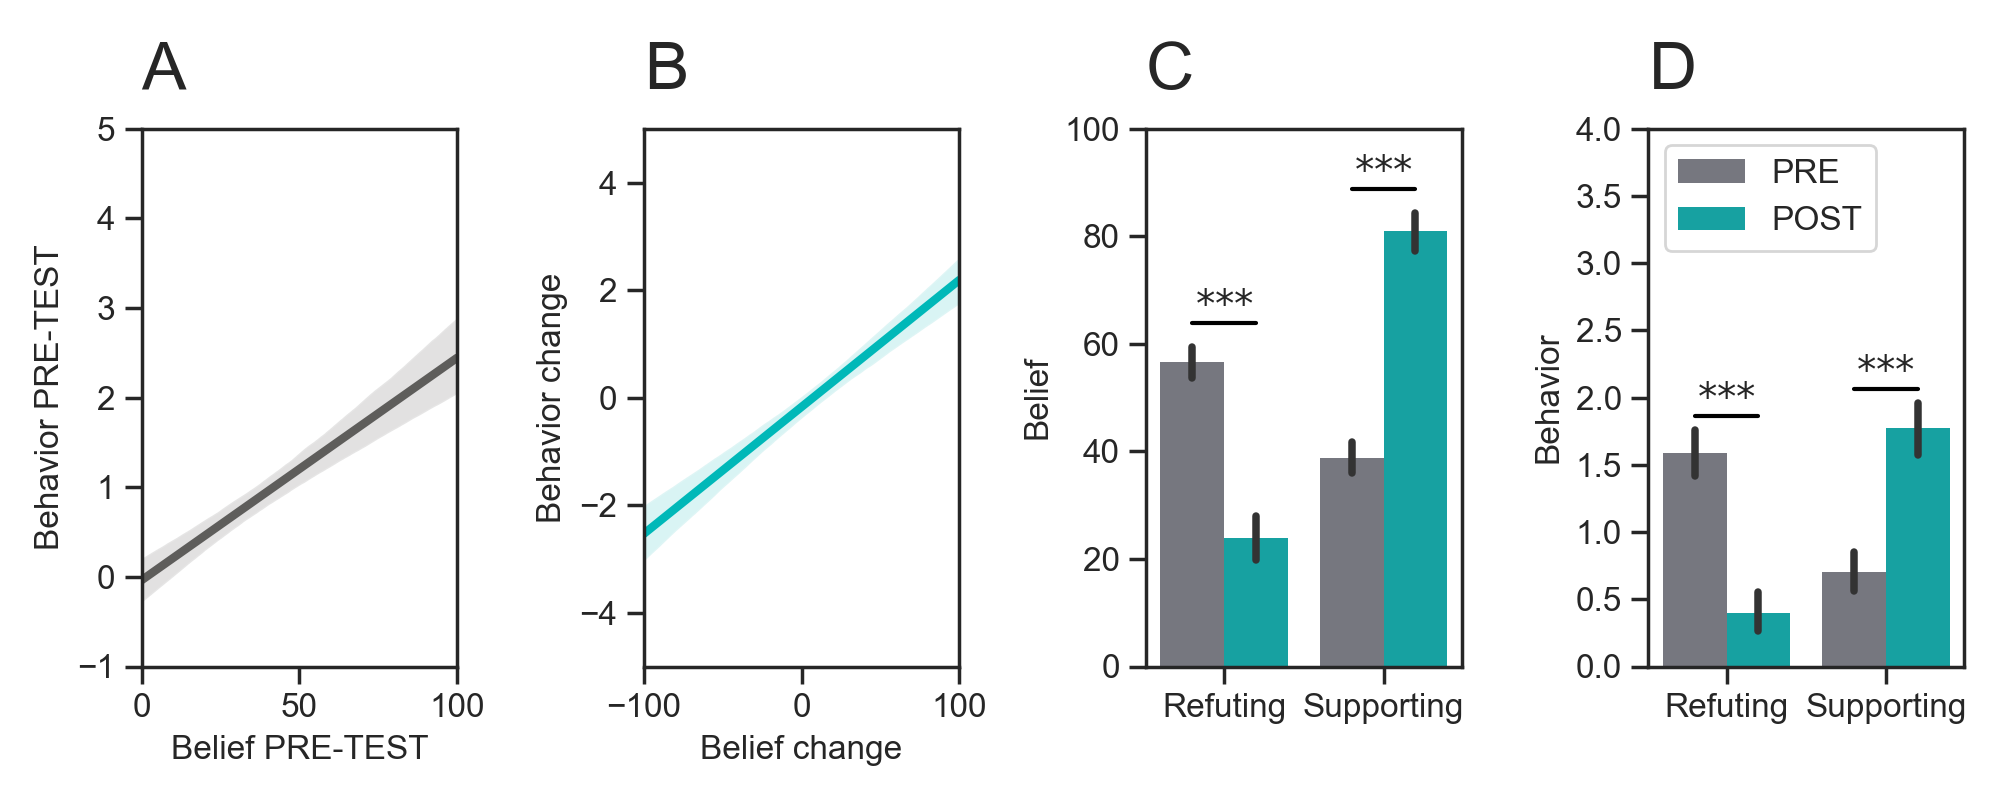

In [17]:
fig, ax = plt.subplots(1,4, figsize=(10,4))

sns.regplot(x=DATA.BeliefPRE, y=DATA.ChoicePRE, scatter_kws={"s": 0}, \
            line_kws={"color":"#3D3C3A","alpha":.8,"lw":3}, ax=ax[0])
ax[0].set_ylim(-1,5)
ax[0].set_ylabel("Behavior PRE-TEST")
ax[0].set_xlabel("Belief PRE-TEST")
bff.panellabel(ax[0], "A")


sns.regplot(x=DATA.deltaB, y=DATA.deltaC, scatter_kws={"s": 0}, \
            line_kws={"color":"#00B8B8","alpha":1,"lw":3}, ax=ax[1])
ax[1].set_ylim(-5,5)
ax[1].set_ylabel("Behavior change")
ax[1].set_xlabel("Belief change")
bff.panellabel(ax[1], "B")

pal1 = ["#747681", "#00B8B8"]

tmp = pd.melt(df2, id_vars=['IncDec'], value_vars=['BeliefPRE', 'BeliefPOST'],
                   var_name='PrePost', value_name='Belief')


sns.barplot(x="IncDec", y="Belief", hue="PrePost", data=tmp, \
            palette=pal1, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[2])
datahandles = np.array([L.get_xydata() for L in ax[2].get_lines()])
_, p = stats.ttest_rel(tmp.loc[np.logical_and(tmp["IncDec"]==0, tmp["PrePost"]=="BeliefPRE"), "Belief"], \
                       tmp.loc[np.logical_and(tmp["IncDec"]==0, tmp["PrePost"]=="BeliefPOST"), "Belief"])
bff.barplot_annotate_brackets(ax[2], 0, 2, p, datahandles, dh=0.05, fs=14)
_, p = stats.ttest_rel(tmp.loc[np.logical_and(tmp["IncDec"]==1, tmp["PrePost"]=="BeliefPRE"), "Belief"], \
                       tmp.loc[np.logical_and(tmp["IncDec"]==1, tmp["PrePost"]=="BeliefPOST"), "Belief"])
bff.barplot_annotate_brackets(ax[2], 1, 3, p, datahandles, dh=0.05, fs=14)
ax[2].set_xticklabels(['Refuting', "Supporting"])
ax[2].set_xlabel("")
ax[2].set_ylim([0,100])
ax[2].get_legend().remove()
bff.panellabel(ax[2], "C")

tmp = pd.melt(df2, id_vars=['IncDec'], value_vars=['ChoicePRE', 'ChoicePOST'],
                   var_name='PrePost', value_name='Choice')

sns.barplot(x="IncDec", y="Choice", hue="PrePost", data=tmp, \
            palette=pal1, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[3]) 
ax[3].get_legend().remove()
ax[3].legend(ax[3].patches[0:3:2], ['PRE', 'POST'], loc="upper left")
datahandles = np.array([L.get_xydata() for L in ax[3].get_lines()])
_, p = stats.ttest_rel(tmp.loc[np.logical_and(tmp["IncDec"]==0, tmp["PrePost"]=="ChoicePRE"), "Choice"], \
                       tmp.loc[np.logical_and(tmp["IncDec"]==0, tmp["PrePost"]=="ChoicePOST"), "Choice"])
bff.barplot_annotate_brackets(ax[3], 0, 2, p, datahandles, dh=0.05, fs=14)

_, p = stats.ttest_rel(tmp.loc[np.logical_and(tmp["IncDec"]==1, tmp["PrePost"]=="ChoicePRE"), "Choice"], \
                       tmp.loc[np.logical_and(tmp["IncDec"]==1, tmp["PrePost"]=="ChoicePOST"), "Choice"])
bff.barplot_annotate_brackets(ax[3], 1, 3, p, datahandles, dh=0.05, fs=14)
ax[3].set_xticklabels(['Refuting', "Supporting"])
ax[3].set_xlabel("")
ax[3].set_ylabel("Behavior")
ax[3].set_ylim([0,4])
bff.panellabel(ax[3], "D")
plt.tight_layout()
plt.savefig('figNSF.jpg', dpi=200, format="jpg")